<a href="https://colab.research.google.com/github/fxnnxc/class-MachineLearning/blob/master/Assignment11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text classification using neural networks

In [0]:
import numpy as np
import re
import nltk
from sklearn.datasets import load_files
#nltk.download('stopwords')
#nltk.download('wordnet')
import pickle
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split


review_data = load_files(r"/content/drive/My Drive/Colab Notebooks/movie_review")
X, y = review_data.data, review_data.target

documents = []

stemmer = WordNetLemmatizer()

for sen in range(0, len(X)):
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(X[sen]))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()
    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    documents.append(document)

num_features = 10000

#vectorizer = CountVectorizer(max_features=num_features, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
#X = vectorizer.fit_transform(documents).toarray()
#tfidfconverter = TfidfTransformer()
#X = tfidfconverter.fit_transform(X).toarray()


In [17]:
word_dict = {}

number = 0 
for d in documents:
  sent = d.split(' ')
  for w in sent:
      if w in word_dict:
        word_dict[w][1] +=1
      else:
        word_dict[w] = [number, 1]
        number+=1

# Number of Sentences S
# Number of Classes N

# Assumes there are more than 100 sentencces
S = len(documents)
low  = 0.005*S
high = 1.0*S

word_dict2 = {}
number = 0
for w in word_dict:
  if low < word_dict[w][1] < high:
    word_dict2[w] = word_dict[w]
    word_dict2[w][0] = number
    number+=1

print(len(word_dict))
print(len(word_dict2))


40125
8260


In [18]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

positive =[] #긍정 레이블에 많이 포함된 단어 목록. 
negative =[] #부정 레이블에 많이 포함된 단어 목록.

X = np.zeros((len(documents), len(word_dict2)))
# Make X
for i, d in enumerate(documents):
  sent = d.split(' ')
  for w in sent:
      try:
        index  = word_dict2[w][0]
        X[i, index] +=1   
      except:
        pass

A = np.concatenate((X, np.ones((X.shape[0],1))), axis=1) # OLS
m = np.linalg.lstsq(A, y, rcond=None)
#A = np.concatenate((X[-600:], np.ones((600,1))), axis=1) # OLS
#m = np.linalg.lstsq(A, y[-600:], rcond=None)

for i in range(len(m[0])-2):
  if m[0][i] > 0.03:
    positive.append(list(word_dict2.keys())[i])
  if m[0][i] < -0.03:
    negative.append(list(word_dict2.keys())[i])

# give more weights for X data 
for i, d in enumerate(documents):
  sent = d.split(' ')
  for w in sent:
      try:
        index  = word_dict2[w][0]
        if w in positive or w in negative:
          X[i, index] += 2
      except:
        pass

# Normalize
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)
print(f"X:{X.shape}")
print(f"y:{y.shape}")



X:(2000, 8260)
y:(2000,)


In [4]:
print(len(positive))


221


In [0]:
# Install CuPy
#!curl https://colab.chainer.org/install | CHAINER_VERSION="==5.1.0" CUPY_VERSION="==5.1.0" sh -
#!apt -y install libcusparse8.0 libnvrtc8.0 libnvtoolsext1
#!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
#!pip install cupy-cuda80
#!pip install cupy
import cupy as cp

In [0]:
def one_hot(y):
  oneHotY = np.zeros((2, y.shape[0]))
  for i in range(y.shape[0]):
    index = int(y[i])
    oneHotY[index][i] = 1
  return oneHotY

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

y_train_index = y_train
y_test_index = y_test

y_train = one_hot(y_train)
y_test  = one_hot(y_test)

X_train = cp.asarray(X_train).T
X_test  = cp.asarray(X_test).T
y_train = cp.asarray(y_train)
y_test  = cp.asarray(y_test)
y_train_index = cp.asarray(y_train_index)
y_test_index  = cp.asarray(y_test_index)

In [0]:
# Utilities [ LOSS, ACCURACY ]
def loss_acc(X, y, y_index):
  H = forward(X)
  v = cp.sum(-cp.multiply(y, cp.log(H)) - cp.multiply(1-y, cp.log(1-H))) + lamb * cp.mean(cp.multiply(outlay,outlay))/2
  
  w = cp.argmax(H, axis=0)
  w = cp.sum(cp.equal(w, y_index))
  return (v, w/H.shape[1]*100)

In [0]:

# Shapes
input_size  = X.shape[1]
layer1_size = num_features//2
layer2_size = num_features//4
output_size = 2

# Weights
layer1 = cp.random.normal(0, 0.3, (layer1_size, input_size))   
layer2 = cp.random.normal(0, 0.3, (layer2_size, layer1_size))  
outlay = cp.random.normal(0, 0.3, (output_size, layer2_size)) 

# Bias
bias1 = cp.zeros((layer1_size, 1))
bias2 = cp.zeros((layer2_size, 1))
bias_ = cp.zeros((output_size, 1))

# stores
loss_train = []
loss_test  = []
acc_train  = []
acc_test   = []

# learing rate
lr =  0.03
lamb = 1e-2
train_size = X_train.shape[1]

In [37]:
print(layer1_size)
print(layer2_size)

5000
2500


In [0]:
# Functions

class classifier():
    def __init__(self):
        self.x = 1


In [0]:
# Functions

def sigmoid(x):  
  return 1/(1+cp.exp(-x))

def forward(x):  # To predict right, worng answer and to calculate loss and accuracy
    global outlay, layer1, layer2, bias1, bias2, bias_
    # Layer 1
    output = layer1.dot(x) + bias1
    output = sigmoid(output)

    # Layer 2 
    output = layer2.dot(output) + bias2
    output = sigmoid(output)  

    # Output layer
    output = outlay.dot(output) + bias_
    output = sigmoid(output)

    return output

def train(x, y):
    global outlay, layer1, layer2,  lr, bias1, bias2, bias_

    # Forward -----------------------------------------------------------------
    # Layer 1
    input1 = x

    output = cp.dot(layer1, x) + bias1
    linval1 = output
    output = sigmoid(output)
    sigval1 = output

    # Layer 2    
    input2 = output
    output = cp.dot(layer2, output) + bias2
    linval2 = output
    output = sigmoid(output)
    sigval2 = output

    # Layer 3  

    # Output layer
    input_ = output
    output = cp.dot(outlay, output) + bias_
    output = sigmoid(output)

    # Backward ----------------------------------------------------------------
    temp_ = output-y                                                       # 역전파값
    dw = cp.dot(temp_, input_.T)/train_size
    db = cp.sum(temp_, axis=1, keepdims=True)/train_size

    outlay -= lr*dw
    outlay -= lr*lamb*outlay
    bias_  -= lr*db

    # layer2
    temp2 = cp.dot(dw.T, temp_)*cp.multiply(sigval2 ,(1-sigval2))           # 역전파값  
    db = cp.sum(temp2, axis=1, keepdims=True)/train_size                   # bias
    dw = np.dot(temp2, input2.T)/train_size                                # weight

    layer2 -= lr*dw
    layer2 -= lr*lamb*layer2
    bias2  -= lr*db

    # layer1
    temp1 = cp.dot(dw.T,temp2) * cp.multiply(sigval1 ,(1-sigval1))         # 역전파  
    db = cp.sum(temp1, axis=1, keepdims=True)/train_size                   # bias
    dw = np.dot(temp1, input1.T)/train_size                                # weight

    layer1 -= lr*dw
    layer1 -= lr*lamb*layer1
    bias1  -= lr*db

    return 

train(X_train, y_train)

In [0]:
# Training

COUNT = 1000

for k in range(0, COUNT+1):

  train(X_train, y_train)
  a,b = loss_acc(X_train, y_train, y_train_index)
  c,d = loss_acc(X_test, y_test, y_test_index)
  loss_train.append(a)
  loss_test.append(c)
  acc_train.append(b)
  acc_test.append(d)


# Result



## Plot the loss curve

The training loss at every iteration of gradient descent

Text(0.5, 1.0, 'Loss Curve')

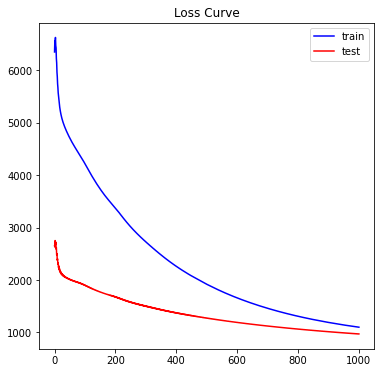

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.plot(loss_train, color='b')
plt.plot(loss_test,  color='r')
plt.legend(['train', 'test'])
plt.title('Loss Curve')

## Plot the accuracy curve

The training accuracy (%) at every iteration of gradient descent

Text(0.5, 1.0, 'Accuracy Curve')

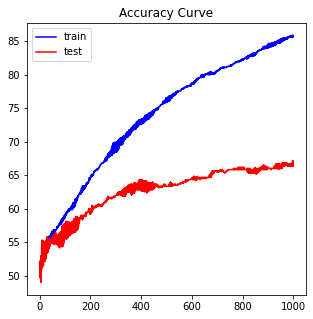

In [42]:
plt.figure(figsize=(5,5))
plt.plot(acc_train, color='b')
plt.plot(acc_test , color='r')
plt.legend(['train', 'test'])
plt.title('Accuracy Curve')

## Plot the quantitative results

In [43]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_train,y_pred_train))
print(classification_report(y_train,y_pred_train))
print(accuracy_score(y_train, y_pred_train))

print(confusion_matrix(y_test,y_pred_test))
print(classification_report(y_test,y_pred_test))
print(accuracy_score(y_test, y_pred_test)


SyntaxError: ignored